In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import umap.plot

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns
from statannotations.Annotator import Annotator
import warnings

## MOA prediction

In [2]:
datasets = ['Stain2', 'Stain3', 'Stain4', 'Stain5']
stratifications = ['training', 'validation', 'test']
bigDF = []
for key in datasets:
    df = pd.read_csv(f'/Users/rdijk/Documents/ProjectFA/FinalModelResults/mAP/{key}/FinalModelResults_{key}.csv')
    # Remove BM columns and append to bottom of DF
    BMmap = pd.DataFrame(df.loc[:, ['plate', 'mAP BM']]).rename(columns={'mAP BM': 'mAP model'})
    df.drop('mAP BM', axis=1, inplace=True)
    df = pd.concat([df, BMmap])
    # Add dataset columns
    df['dataset'] = [key]*len(df)
    # Add method columns
    df['method'] = ['model']*(len(df)//2) + ['baseline']*(len(df)//2)
    # Add platelabels
    platelabels = pd.read_csv(f'/Users/rdijk/Documents/ProjectFA/Benchmarks/platelabels{key}.csv')
    df = df.merge(platelabels, on='plate')
    bigDF.append(df)
bigDF = pd.concat(bigDF)

In [3]:
print(bigDF.shape)
bigDF

(84, 11)


,plate,mAP model,dataset,method,platelabel,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,BR00112202,0.178249,Stain2,model,training,NaN,NaN,NaN,NaN,NaN,NaN
1,BR00112202,0.098738,Stain2,baseline,training,NaN,NaN,NaN,NaN,NaN,NaN
2,BR00112197standard,0.168084,Stain2,model,validation,NaN,NaN,NaN,NaN,NaN,NaN
3,BR00112197standard,0.098116,Stain2,baseline,validation,NaN,NaN,NaN,NaN,NaN,NaN
4,BR00112199,0.106735,Stain2,model,test,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5,BR00120532,0.121583,Stain5,baseline,test,NaN,NaN,NaN,NaN,NaN,NaN
6,BR00120536,0.029385,Stain5,model,test,NaN,NaN,NaN,NaN,NaN,NaN
7,BR00120536,0.122782,Stain5,baseline,test,NaN,NaN,NaN,NaN,NaN,NaN
8,BR00120526,0.133091,Stain5,model,test,NaN,NaN,NaN,NaN,NaN,NaN


Stain2_model vs. Stain2_baseline: Welch's t-test independent samples, P_val:1.249e-07 t=1.890e+01
Stain2_model vs. Stain2_baseline: Welch's t-test independent samples, P_val:7.481e-06 t=1.434e+01
Stain2_model vs. Stain2_baseline: Welch's t-test independent samples, P_val:1.721e-01 t=1.944e+00
Stain3_model vs. Stain3_baseline: Welch's t-test independent samples, P_val:3.450e-05 t=1.519e+01
Stain3_model vs. Stain3_baseline: Welch's t-test independent samples, P_val:5.354e-05 t=1.294e+01
Stain3_model vs. Stain3_baseline: Welch's t-test independent samples, P_val:3.216e-02 t=3.685e+00
Stain4_model vs. Stain4_baseline: Welch's t-test independent samples, P_val:1.270e-05 t=1.147e+01
Stain4_model vs. Stain4_baseline: Welch's t-test independent samples, P_val:1.565e-06 t=2.261e+01
Stain4_model vs. Stain4_baseline: Welch's t-test independent samples, P_val:1.179e-02 t=7.074e+00
Stain5_model vs. Stain5_baseline: Welch's t-test independent samples, P_val:5.027e-02 t=-2.660e+00


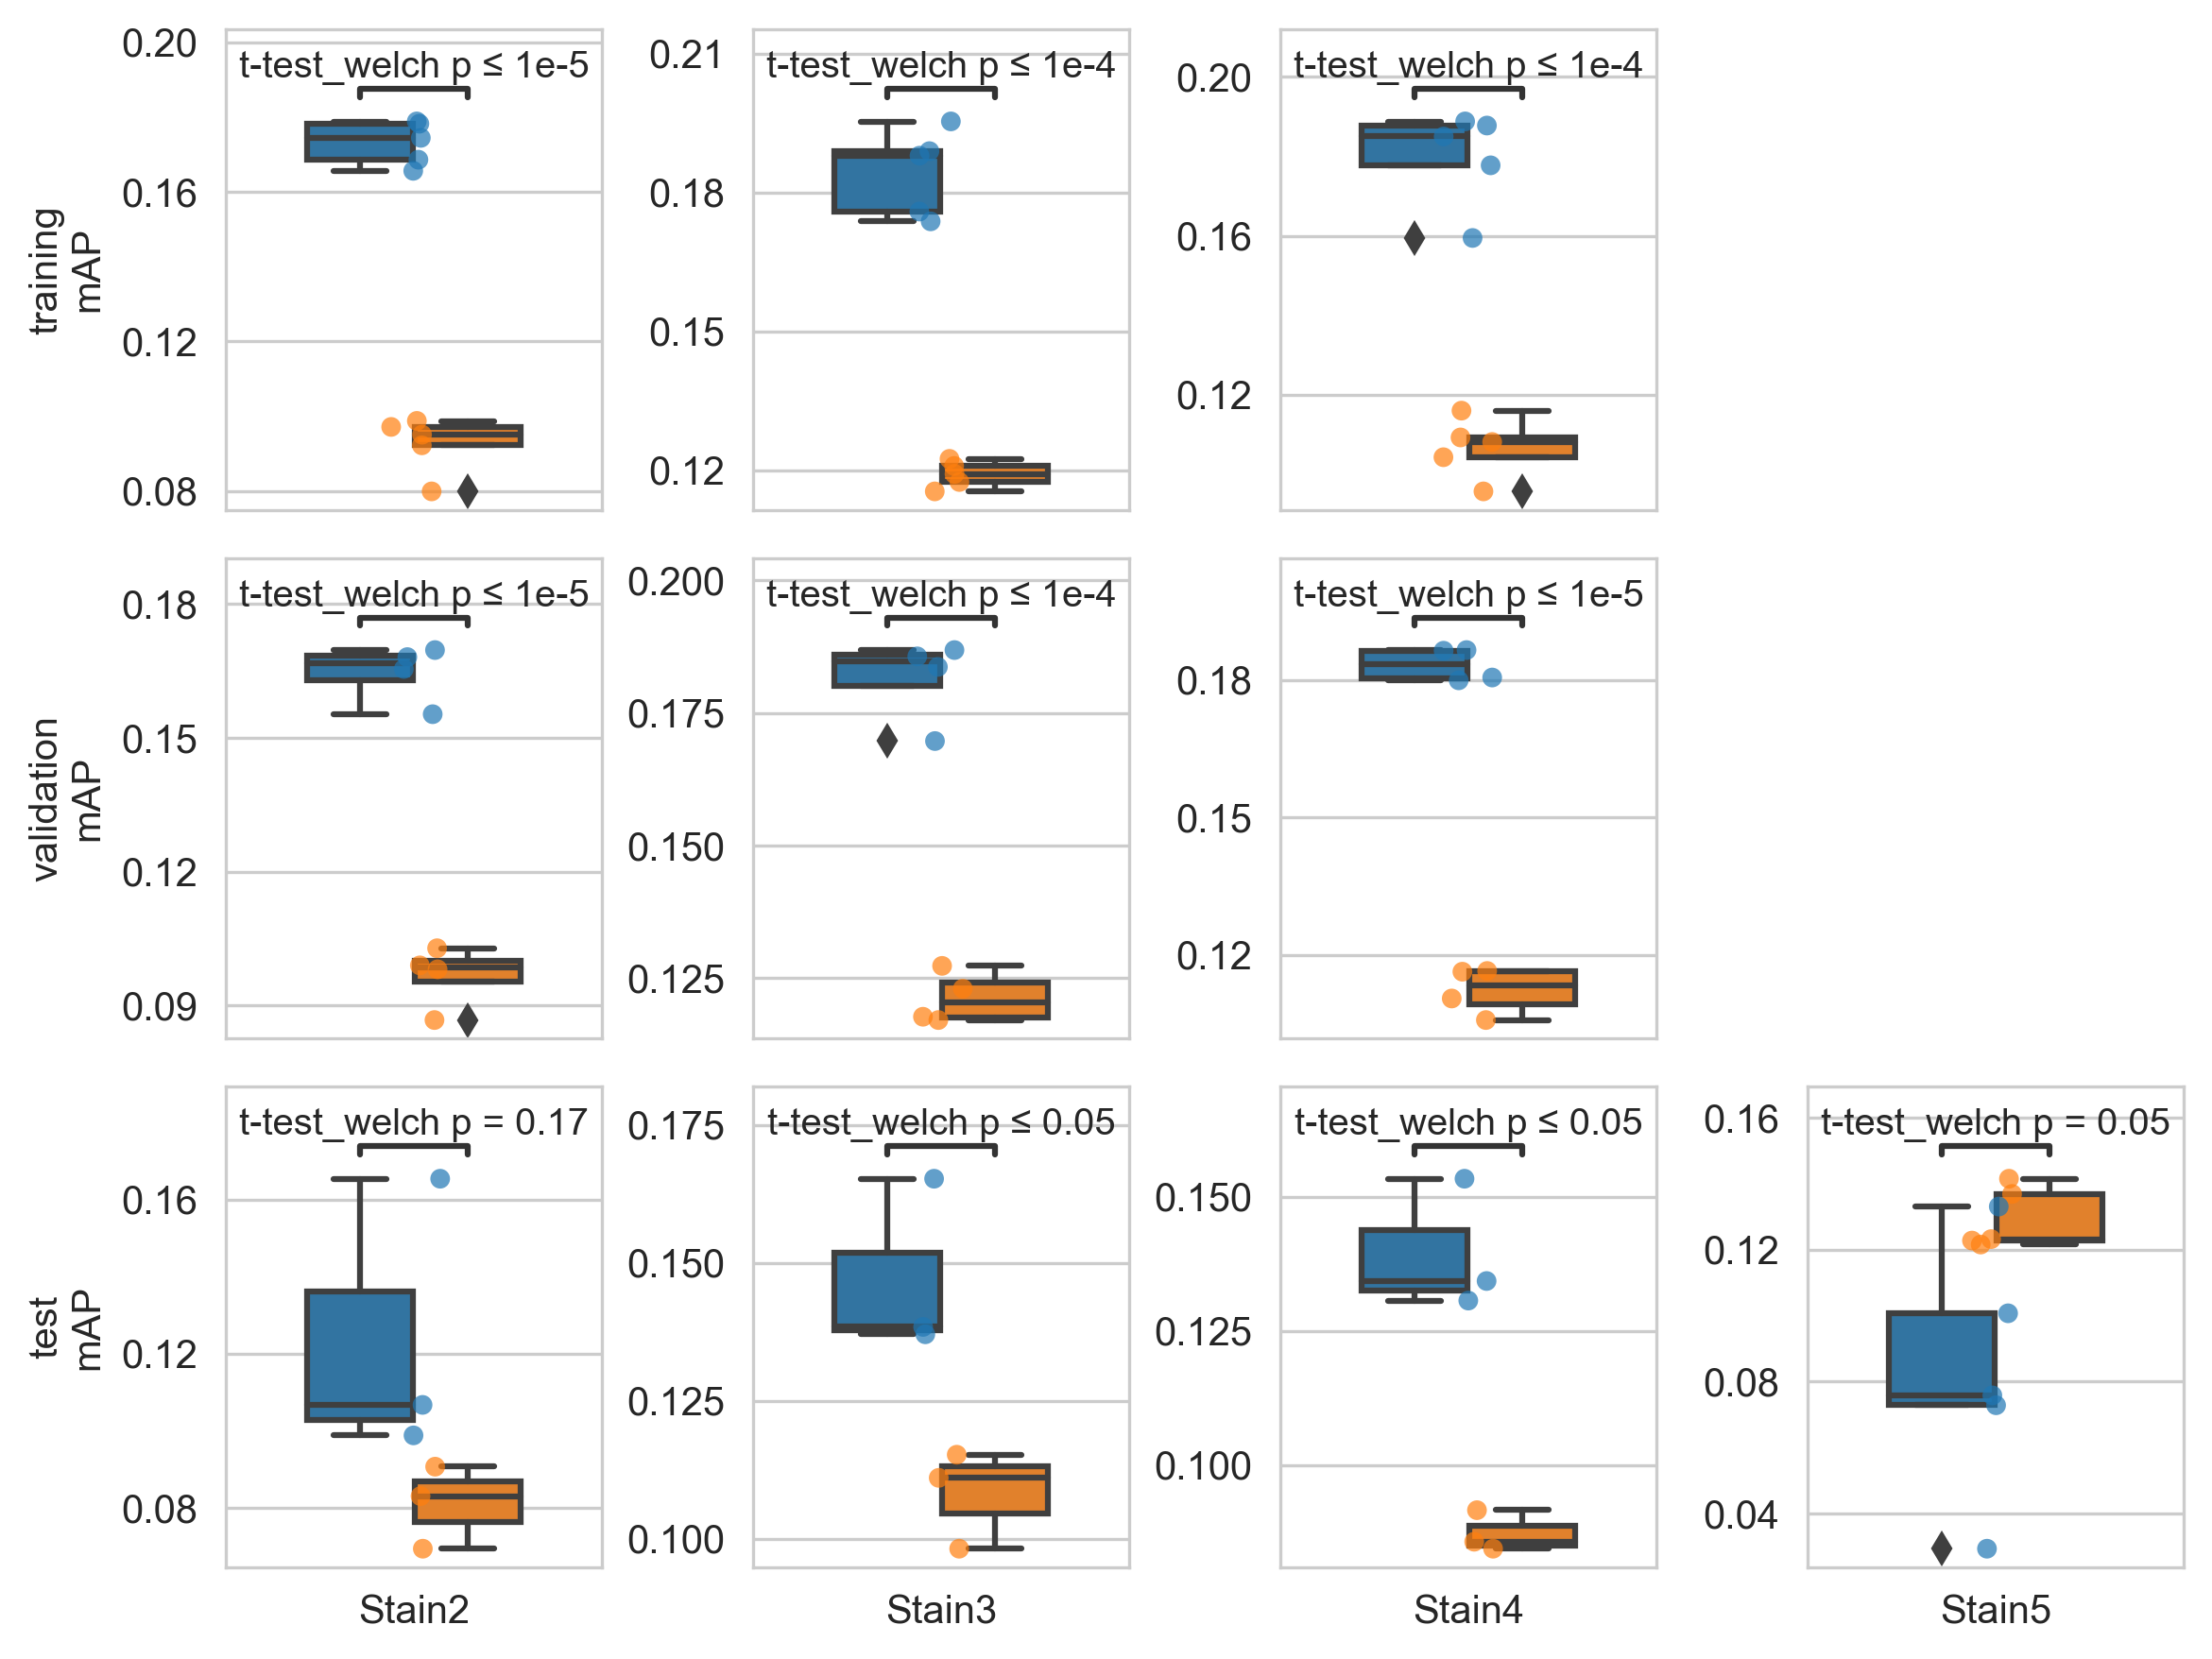

In [18]:
sns.set_style("whitegrid")

x = "dataset"
y = "mAP model"
hue = "method"
display_method = 'simple' # star full simple

fig, ax = plt.subplots(3, 4, dpi=300, figsize=(8, 6))
# First loop over different datasets 
for dataset_idx in range(4):
    cdataset = datasets[dataset_idx]
    subDF = bigDF.loc[bigDF['dataset'] == cdataset]
    # Then over different stratifications 
    for strat_idx in range(3):
        if dataset_idx==3 and strat_idx<2:
            continue
        subsubDF = subDF.loc[subDF['platelabel'] == stratifications[strat_idx]]
        #print(np.mean(np.array(subsubDF['mAP model'][subsubDF.method == 'model']-np.array(subsubDF['mAP model'][subsubDF.method == 'baseline'])))/np.mean(subsubDF['mAP model'][subsubDF.method == 'baseline']))
        #print(subsubDF)
        with sns.plotting_context("notebook", font_scale = 0.8):
            subax = sns.boxplot(data=subsubDF, x=x, y=y, hue=hue, ax=ax[strat_idx, dataset_idx])
            sns.stripplot(data=subsubDF, x=x, y=y, hue=hue, ax=ax[strat_idx, dataset_idx], alpha=0.7)
            box_pairs=[((cdataset, 'model'), (cdataset, 'baseline'))]

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                annotator = Annotator(subax, pairs=box_pairs, data=subsubDF, x=x, y=y, hue=hue)
                annotator.configure(test='t-test_welch', text_format=display_method, 
                                    loc='inside', test_short_name='t-test welch')
                annotator.apply_and_annotate()

            # remove all the labels and ticks 
            if strat_idx != 2:
                subax.set(xticklabels=[])
            subax.set(xlabel=None)
            subax.tick_params(bottom=False)
            if dataset_idx != 0:
                subax.set(ylabel=None)
            else:
                if strat_idx==0:
                    subax.set(ylabel='training\nmAP')
                elif strat_idx==1:
                    subax.set(ylabel='validation\nmAP')
                else:
                    subax.set(ylabel='test\nmAP')
            subax.legend([],[], frameon=False)
            subax.yaxis.set_major_locator(plt.MaxNLocator(4))

plt.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.4)
fig.delaxes(ax[0][3])
fig.delaxes(ax[1][3])

plt.savefig('/Users/rdijk/Documents/ProjectFA/FinalModelResults/MOAmAP.png', bbox_inches='tight')


# Percent Replicating scores

In [7]:
Stain2 = pd.DataFrame({
    'plate': ['BR00112202', 'BR00112197binned', 'BR00112197standard', 'BR00112198', 'BR00112197repeat', 'BR00112204',
             'BR00112201'] *4,
    'mAP': [0.70, 0.73, 0.65, 0.63, 0.61, 0.62, 0.68, 
            0.34, 0.41, 0.40, 0.35, 0.41, 0.35, 0.40,
            0.56, 0.56, 0.53, 0.54, 0.53, 0.53, 0.54,
            0.30, 0.30, 0.28, 0.30, 0.31, 0.29, 0.32],
    'Method': ['model']*7 + ['baseline']*7 + ['model']*7 + ['baseline']*7,
    'Compound dataset': ['Training'] * 14 + ['Validation'] * 14,
    'PlateLabel': ['Training', 'Training', 'Validation', 'Validation', 'Validation', 'Validation', 'Validation']*4
})

Stain3 = pd.DataFrame({
    'plate': ['BR00115128', 'BR00115125highexp', 'BR00115133highexp', 'BR00115131', 'BR00115128highexp', 'BR00115134',
             'BR00115125', 'BR00115126', 'BR00115133', 'BR00115127', 'BR00115129']*4,
    'mAP': [0.69, 0.68, 0.75, 0.68, 0.64, 0.62, 0.61, 0.38, 0.65, 0.63, 0.59,
            0.39, 0.37, 0.38, 0.38, 0.40, 0.37, 0.36, 0.32, 0.38, 0.38, 0.38,
            0.56, 0.41, 0.47, 0.54, 0.59, 0.48, 0.46, 0.36, 0.42, 0.52, 0.55,
            0.32, 0.31, 0.31, 0.29, 0.33, 0.33, 0.29, 0.28, 0.30, 0.31, 0.32],
    'Method': ['model']*11 + ['baseline']*11 + ['model']*11 + ['baseline']*11,
    'Compound dataset': ['Training'] * 22 + ['Validation'] * 22,
    'PlateLabel': ['Training', 'Training', 'Training' , 'Training', 'Validation', 'Validation', 'Validation', 
              'Validation', 'Validation', 'Validation', 'Validation']*4

})

Stain4 = pd.DataFrame({
    'plate': ['BR00116631', 'BR00116627', 'BR00116630highexp', 'BR00116631highexp', 'BR00116625highexp', 
              'BR00116628highexp', 'BR00116625', 'BR00116629highexp', 'BR00116627highexp', 
              'BR00116629', 'BR00116628']*4,
    'mAP': [0.65, 0.69, 0.69, 0.60, 0.61, 0.64, 0.58, 0.64, 0.62, 0.62, 0.62,
            0.30, 0.30, 0.29, 0.30, 0.32, 0.32, 0.31, 0.29, 0.31, 0.30, 0.32,
            0.32, 0.39, 0.40, 0.30, 0.42, 0.37, 0.39, 0.41, 0.48, 0.37, 0.31, 
            0.28, 0.29, 0.30, 0.30, 0.28, 0.31, 0.29, 0.29, 0.27, 0.29, 0.29],
    'Method': ['model']*11 + ['baseline']*11 + ['model']*11 + ['baseline']*11,
    'Compound dataset': ['Training'] * 22 + ['Validation'] * 22,
    'PlateLabel': ['Training', 'Training', 'Training', 'Validation', 'Validation', 'Validation', 
              'Validation', 'Validation', 'Validation', 'Validation', 'Validation']*4
})

Stain5 = pd.DataFrame({
    'plate': ['BR00120530', 'BR00120530confocal', 'BR00120526confocal', 'BR00120526', 'BR00120536confocal', 'BR00120536',
'BR00120532confocal', 'BR00120532', 'BR00120274', 'BR00120274confocal', 'BR00120270', 'BR00120270confocal']*4,
    'mAP': [0.26, 0.03, 0.03, 0.35, 0.06, 0.02, 0.05, 0.15, 0.17, 0.03, 0.25, 0.02,
            0.28, 0.29, 0.29, 0.28, 0.25, 0.25, 0.24, 0.23, 0.23, 0.21, 0.26, 0.26,
            0.23, 0.03, 0.02, 0.38, 0.05, 0.03, 0.06, 0.18, 0.21, 0.03, 0.29, 0.03, 
            0.39, 0.40, 0.36, 0.37, 0.37, 0.35, 0.35, 0.38, 0.34, 0.36, 0.38, 0.39],
    'Method': ['model']*12 + ['baseline']*12 + ['model']*12 + ['baseline']*12,
    'Compound dataset': ['Training'] * 24 + ['Validation'] * 24,
    'Batch': ['CondA PE', 'CondA PE', 'CondA Thermo', 'CondA Thermo', 'CondB PE', 'CondB PE', 'CondB Thermo',
              'CondB Thermo', 'CondC PE', 'CondC PE', 'CondC Thermo', 'CondC Thermo']*4
})







# Percent Matching scores

In [6]:
Stain2 = pd.DataFrame({
    'plate': ['BR00112202', 'BR00113818', 'BR00112198', 'BR00112197repeat', 'BR00112204', 'BR00113820', 
              'BR00113821', 'BR00112197binned', 'BR00112201'] *2 +['All'],
    'mAP': [0.18, 0.18, 0.15, 0.15, 0.16, 0.19, 0.16, 0.18, 0.16, 
           0.10, 0.08, 0.07, 0.10, 0.09, 0.09, 0.09, 0.10, 0.10,
           0.0112],
    'Method': ['model']*9 + ['baseline']*9 + ['shuffled'],
    'PlateLabel': ['Training', 'Training', 'Validation', 'Training', 'Validation', 'Training', 
                   'Training', 'Training','Validation']*2 + ['Shuffled']
})


Stain3 = pd.DataFrame({
    'plate': ['BR00115126', 'BR00115134bin1']*2 + ['All'],
    'mAP': [0.13, 0.19,
            0.10, 0.11,
            0.0112],
    'Method': ['model']*2 + ['baseline']*2 + ['shuffled'],
    'PlateLabel': ['Validation', 'Validation']*2 + ['Shuffled']

})

Stain4 = pd.DataFrame({
    'plate': ['BR00116625highexp', 'BR00116625', 'BR00116633bin1', '044247-Vbin1_FS', '015124-Vhighexp_FS',
             '015124-V_FS']*2 + ['All'],
    'mAP': [0.16, 0.16, 0.19, 0.18, 0.18, 0.17,
            0.12, 0.12, 0.09, 0.08, 0.10, 0.09,
            0.0112],
    'Method': ['model']*6 + ['baseline']*6 + ['shuffled'],
    'PlateLabel': ['Validation', 'Validation', 'Training', 'Training', 'Training', 'Training']*2 + ['Shuffled']
})

# Random shuffle mAP for matching:  0.011235955056179775 

In [8]:
x_division = "PlateLabel" # 'Compound dataset // PlateLabel'
fig = px.box(Stain2, y="mAP", color="Method", x=x_division,
         title="mAP of model versus baseline (Stain2)",
         hover_data=["plate", "PlateLabel"], points='all'
        )

fig.show()


In [9]:
x_division = "PlateLabel" # 'Compound dataset // PlateLabel'
fig = px.box(Stain3, y="mAP", color="Method", x=x_division,
         title="mAP of model versus baseline (Stain3)",
         hover_data=["plate", "PlateLabel"], points='all'
        )

fig.show()


In [10]:
x_division = "PlateLabel" # 'Compound dataset // PlateLabel'
fig = px.box(Stain4, y="mAP", color="Method", x=x_division,
         title="mAP of model versus baseline (Stain4)",
         hover_data=["plate", "PlateLabel"], points='all'
        )

fig.show()


In [6]:
x_division = "Compound dataset" # 'Compound dataset // Batch'
fig = px.box(Stain5, y="mAP", color="Method", x=x_division,
         title="mAP of model versus baseline (Stain5)",
         hover_data=["plate", "Batch"], points='all'
        )

fig.show()
